In [50]:
import sys
import numpy as np
# import scikitlearn
import matplotlib.pyplot as plt
import pandas as pd
import glob

# ML Magic:
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import (
    train_test_split,
    KFold
)

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    mean_squared_error
)

# Local includes:
sys.path.append("../../src/")
import therm_params as tp
from power_model import (
    leakagePower,
    peripheral_power,
    board_power
)


In [5]:
# blackscholes_files = glob.glob("../blackscholes_benchmarking/*.csv")
blackscholes_files = ["../blackscholes_benchmarking/userspace_ondemand_blackscholes.csv"]
bodytrack_files = glob.glob("../bodytrack_benchmarking/*.csv")
random_data = ["../random_test.csv"]
files = random_data

In [91]:
df_list = []

def leak_row_big(row):
    return leakagePower(tp.c1, tp.c2, tp.Igate, row.volts_big_cluster, \
            np.max( [row.temp4, row.temp5, row.temp6, row.temp7] ) + 273.15)
    
def leak_row_little(row):
    return leakagePower(tp.c1, tp.c2, tp.Igate, row.volts_little_cluster, \
            np.mean( [row.temp4, row.temp5, row.temp6, row.temp7, row.temp_gpu] ) + 273.15)

def leak_row_gpu(row):
    return leakagePower(tp.c1, tp.c2, tp.Igate, row.volts_gpu, row.temp_gpu + 273.15 )

def leak_row_mem(row):
    return leakagePower(tp.c1, tp.c2, tp.Igate, row.volts_mem, \
            np.max( [row.temp4, row.temp5, row.temp6, row.temp7] ) + 273.15)

for file in files:
    df = pd.read_csv(file, index_col=False, header=0, sep='\t')
    df_list.append(df)

# for file in bodytrack_files:
#     df = pd.read_csv(file, index_col=False, header=0, sep='\t')
#     df_list.append(df)
def process_dataframe_list(df_list):
    data = pd.concat(df_list, ignore_index=True)
    # Drop all measurements where watts <= 0:
    data = data.loc[data.watts > 0]
    # fill in the potentially missing voltage values
    data["volts_big_cluster"] = data.freq_big_cluster.map(lambda x: tp.big_f_to_v[float(x)/1000000000])
    data["volts_little_cluster"] = data.freq_little_cluster.map(lambda x: tp.little_f_to_v[float(x)/1000000000])
    # Replace with correct value for gpu and mem voltage:
    # data["volts_gpu"] = 1.0
    # data["volts_mem"] = 1.2
    # Recompute the leakage power:
    data['leak_big'] = data.apply(leak_row_big, axis=1)
    data['leak_little'] = data.apply(leak_row_little, axis=1)
    # data['leak_gpu'] = data.apply(leak_row_gpu, axis=1)
    # data['leak_mem'] = data.apply(leak_row_mem, axis=1)
    data['w_leak2'] = data.apply(lambda row: np.sum( [row.leak_big, row.leak_little] ), axis=1)

    data_filtered = pd.DataFrame()
    data_filtered["usage_little"] = data[["usage_c0", "usage_c1", "usage_c2", "usage_c3"]].apply(func = np.sum, axis=1)
    data_filtered["usage_big"] = data[["usage_c4", "usage_c5", "usage_c6", "usage_c7"]].apply(func = np.sum, axis=1)
    data_filtered["max_temp_big"] = data[["temp4", "temp5", "temp6", "temp7"]].apply(func = np.max, axis=1)
    data_filtered["avg_temp_big"] = data[["temp4", "temp5", "temp6", "temp7"]].apply(func = np.mean, axis=1)
    data_filtered["gpu_temp"] = data.temp_gpu
    data_filtered["vvf_b"] = data.freq_big_cluster.map(lambda x: tp.big_f_to_v[float(x)/1000000000]**2 * x)
    data_filtered["vvf_l"] = data.freq_little_cluster.map(lambda x: tp.little_f_to_v[float(x)/1000000000]**2 * x)
    data_filtered["p_dyn"] = data.apply(lambda row: row.watts - row.w_leak2 - peripheral_power, axis=1)
    data_filtered["aVVFb"] = data_filtered.apply(lambda row: row.usage_big * row.vvf_b, axis=1)
    data_filtered["aVVFl"] = data_filtered.apply(lambda row: row.usage_little * row.vvf_l, axis=1)
    data_filtered["gpu_mem"] = 1
    data_filtered['p_total'] = data.watts
    return data_filtered

data_filtered = process_dataframe_list(df_list)

In [92]:
data_filtered.head(10)

,usage_little,usage_big,max_temp_big,avg_temp_big,gpu_temp,vvf_b,vvf_l,p_dyn,aVVFb,aVVFl,gpu_mem,p_total
1,0.000000,0.000000,57.0,55.25,53.0,486000000.0,1.155625e+09,0.998293,0.000000e+00,0.000000e+00,1,3.416
2,0.000000,0.000000,57.0,55.00,53.0,486000000.0,1.155625e+09,0.998824,0.000000e+00,0.000000e+00,1,3.416
3,0.047619,0.050000,57.0,55.00,53.0,486000000.0,1.155625e+09,0.697824,2.430000e+07,5.502976e+07,1,3.115
4,0.000000,0.050000,56.0,54.75,53.0,486000000.0,1.155625e+09,0.692680,2.430000e+07,0.000000e+00,1,3.107
5,0.000000,0.047619,56.0,54.75,53.0,486000000.0,1.155625e+09,0.703680,2.314286e+07,0.000000e+00,1,3.118
6,0.000000,0.050000,56.0,54.75,53.0,486000000.0,1.155625e+09,0.703680,2.430000e+07,0.000000e+00,1,3.118
7,0.000000,0.000000,56.0,54.75,53.0,486000000.0,1.155625e+09,0.700680,0.000000e+00,0.000000e+00,1,3.115
8,0.000000,0.050000,56.0,54.75,53.0,486000000.0,1.155625e+09,0.692680,2.430000e+07,0.000000e+00,1,3.107
9,0.000000,0.000000,56.0,54.75,53.0,486000000.0,1.155625e+09,0.688680,0.000000e+00,0.000000e+00,1,3.103
10,0.000000,0.047619,56.0,54.75,53.0,486000000.0,1.155625e+09,0.688680,2.314286e+07,0.000000e+00,1,3.103


In [105]:
X = data_filtered.loc[:, ["aVVFb", "vvf_b", "aVVFl", "vvf_l", "gpu_mem"]]
y = data_filtered.p_dyn#p_total

# Estimate C values for the model (built-in cross validation):
DPM = RidgeCV(alphas = np.linspace(.1, 10, 50), cv=2)
# # Create training and test sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, shuffle=True) 
DPM = DPM.fit(X_train,y_train)
P = DPM.predict(X_test)

In [106]:
R = DPM.score(X_test, y_test)
R

0.83026165079801995

In [107]:
mean_squared_error( list(y_test.values), list(P) )

0.10540280142915501

In [108]:
pd.DataFrame([list(P), list(y_test.values)] )

,0,1,2,3,4,5,6,7,8,9,...,32990,32991,32992,32993,32994,32995,32996,32997,32998,32999
0,3.051039,1.346021,0.834869,1.424518,1.133220,1.079129,1.309311,0.693931,1.597234,0.918281,...,1.449221,0.740827,1.428144,0.843197,1.148202,1.458916,1.067906,1.304347,2.239034,1.137170
1,3.512941,1.383451,0.822042,1.440087,0.929085,1.230357,1.325444,0.711696,1.961784,0.705372,...,1.280336,0.671372,0.991310,0.966053,1.569027,1.353550,0.962220,0.711129,2.230727,1.248887


In [109]:
# Load some other data and test/plot it:
f_test = "../blackscholes_benchmarking/userspace_ondemand_blackscholes.csv"
# f_test = "../random_test2.csv"
to_plot = pd.read_csv(f_test, index_col=False, header=0, sep='\t')
other_XY = process_dataframe_list([to_plot])

In [110]:
X_plot = other_XY.loc[:, ["aVVFb", "vvf_b", "aVVFl", "vvf_l", "gpu_mem"]]
y_plot = other_XY.p_dyn

In [111]:
P_plot = DPM.predict(X_plot)
DPM.score(X_plot, y_plot)

0.96747132144940939

In [112]:
mean_squared_error( list(y_plot.values), list(P_plot) )

0.16804096861943182

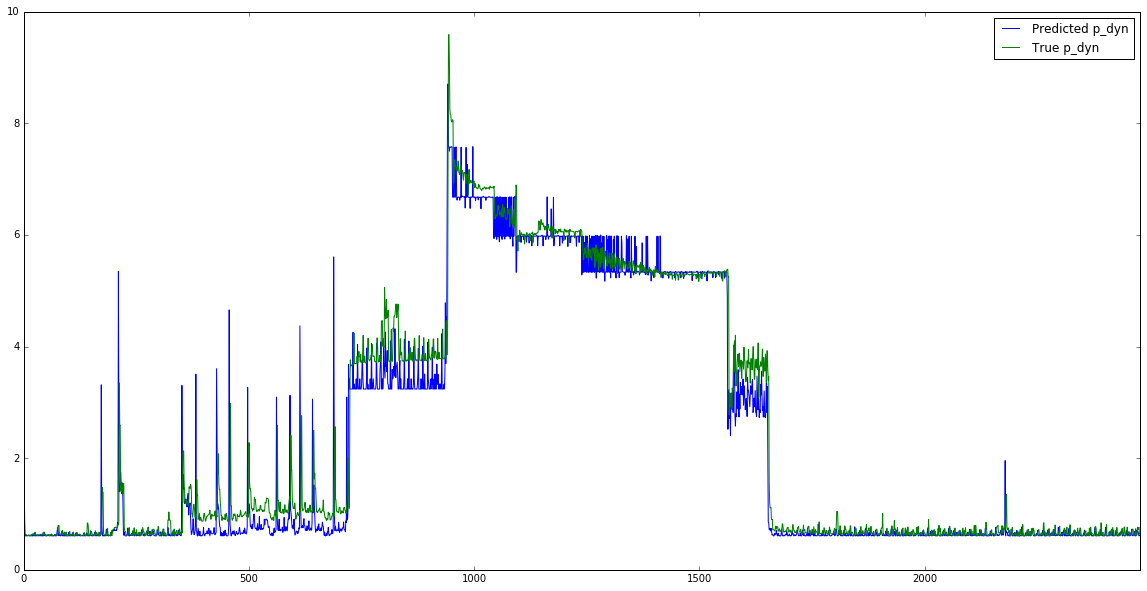

In [113]:
plt.rcParams["figure.figsize"] = [20,10]
plt.plot(range(len(P_plot)), P_plot, label="Predicted p_dyn")
y_plot.plot(label="True p_dyn")
plt.legend()
plt.show()

In [114]:
X_hack = np.identity(5)
y_hack = DPM.predict(X_hack)
y_hack

array([ 0.55566051,  0.55566051,  0.5556605 ,  0.5556605 ,  0.5556605 ])